# 4 Linear Regression Model

## 4.1 Data Preprocessing

In [1]:
%matplotlib inline
# import required modules for prediction tasks
import numpy as np
import pandas as pd
import math
import random
import requests
import zipfile
from io import StringIO
import re
import json
import os
import matplotlib
import matplotlib.pyplot as plt

# sklearn functions used for the linear regression model
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_absolute_error

First, let us again establish a baseline which has to be beaten by our model. To get a feeling for a good baseline we pick flights from from Boston(all airports) to Los Angles(all airports). And collecting dataset from 2011 to 2015. This data set is larger than the dataset used in the former random forest regression.

In [2]:
print('loading data...')
bigdf = pd.read_csv('Big10FlightTable.csv')
years = ['2011', '2012', '2013', '2014', '2015']

loading data...


In [4]:
bigdf.columns

Index(['Unnamed: 0', 'level_0', 'Unnamed: 0.1', 'TailNum', 'DayofMonth',
       'Cancelled', 'ArrTime', 'Year', 'Month', 'OriginCityName', 'FlightNum',
       'DayOfWeek', 'Origin', 'OriginWac', 'AirlineID', 'Quarter', 'Diverted',
       'ArrDelayMinutes', 'DepTime', 'UniqueCarrier', 'Distance', 'ArrDelay',
       'OriginStateName', 'DestCityName', 'Dest', 'ArrDel15', 'AIRCRAFT_YEAR',
       'AIRCRAFT_MFR', 'AIRCRAFT_AGE'],
      dtype='object')

In [5]:
# specify here which cities should be investigated
city_from = 'Boston, MA'
city_to = 'Los Angeles, CA'

# filter for cities
bigdf = bigdf[(bigdf.OriginCityName == city_from) & (bigdf.DestCityName == city_to)]

We want to departure at 12.18. We want to use historical data to make a flight prediction

In [6]:
query_day = 18
query_month = 12

# how many flights do exist in all years?
flights = []
flightvalues = []
for y in years:
    query = list(bigdf[(bigdf.Year == int(y)) & (bigdf.Month == query_month) & (bigdf.DayofMonth == query_day)].FlightNum.astype(int).unique())
    flights.append(query)
    flightvalues += query
    
# build a matrix
data_matrix = np.zeros((len(flightvalues), len(years)))
# build dict
flightdict = dict(zip(flightvalues, np.arange(0, len(flightvalues))))

# fill datamatrix
for i in range(len(years)):
    for j in flights[i]:
        data_matrix[flightdict[j], i] = 1.

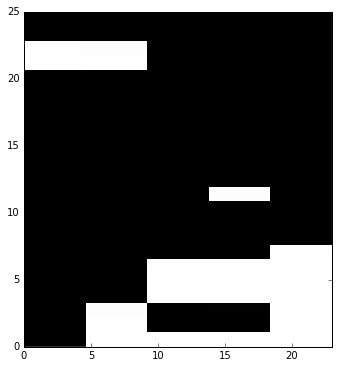

In [10]:
# plot matrix
plt.figure(figsize=(10, 6))
plt.imshow(data_matrix, extent=[0,data_matrix.shape[0],0,data_matrix.shape[1] * 5], interpolation='none', cmap='gray')

As seem in the graph above, the comparison by features for individual flights is not really possible. It seems as if airlines change their flight numbers on a yearly basis

In [98]:
dffordate = bigdf[bigdf.Month == query_month]
dffordate = dffordate[dffordate.DayofMonth == query_day]
dffordate.head()

,Unnamed: 0,level_0,Unnamed: 0.1,TailNum,DayofMonth,Cancelled,ArrTime,Year,Month,OriginCityName,...,ArrDelay,OriginStateName,DestCityName,Dest,ArrDel15,AIRCRAFT_YEAR,AIRCRAFT_MFR,AIRCRAFT_AGE,HOUR_OF_ARR,HOUR_OF_DEP
3866214,3866214,3866214,3866214,537JB,18,0.0,1131.0,2011,12,"Boston, MA",...,-24.0,Massachusetts,"Los Angeles, CA",LAX,0.0,2012,SMALL,-1,113,81
3866215,3866215,3866215,3866215,712JB,18,0.0,2245.0,2011,12,"Boston, MA",...,-2.0,Massachusetts,"Los Angeles, CA",LAX,0.0,2008,AIRBUS,3,224,191
7902808,7902808,3834359,3834359,805JB,18,0.0,1149.0,2012,12,"Boston, MA",...,11.0,Massachusetts,"Los Angeles, CA",LAX,0.0,2012,AIRBUS,0,114,80
7902809,7902809,3834360,3834360,784JB,18,0.0,2246.0,2012,12,"Boston, MA",...,11.0,Massachusetts,"Los Angeles, CA",LAX,0.0,2011,AIRBUS,1,224,185
8097491,8097491,4029042,4029042,587UA,18,0.0,2158.0,2012,12,"Boston, MA",...,38.0,Massachusetts,"Los Angeles, CA",LAX,1.0,1993,BOEING,19,215,175


In [32]:
dffordate.columns

Index(['Unnamed: 0', 'level_0', 'Unnamed: 0.1', 'TailNum', 'DayofMonth',
       'Cancelled', 'ArrTime', 'Year', 'Month', 'OriginCityName', 'FlightNum',
       'DayOfWeek', 'Origin', 'OriginWac', 'AirlineID', 'Quarter', 'Diverted',
       'ArrDelayMinutes', 'DepTime', 'UniqueCarrier', 'Distance', 'ArrDelay',
       'OriginStateName', 'DestCityName', 'Dest', 'ArrDel15', 'AIRCRAFT_YEAR',
       'AIRCRAFT_MFR', 'AIRCRAFT_AGE'],
      dtype='object')

In [99]:
def predict_base_model(X):
    return np.array([dffordate.ArrDelay.mean()]*X.shape[0])

To test the quality of this model, we use the last year as test set and the previous as train data. The idea is, that we are always interested in predicting the next year somehow. Thus, if the match for 2015 is good, we expect it to be the same for 2016.

In [127]:
# build test/train set
df_train = dffordate[dffordate.Year != int(years[-1])]
df_test = dffordate[dffordate.Year == int(years[-1])]

y_train = df_train.ArrDelay
X_train = y_train # here dummy
y_test = df_test.ArrDelay
X_test = y_test # here dummy

In our baseline, it seems that, at average, the flight will delay for about 11.78 mins

In [156]:
y_pred = predict_base_model(X_test)
y_pred[0]

11.782608695652174

### The RMSE value of baseline

We can use the root mean squared error as one measurement to evaluate the performance of regression model. In our case, the RMSE value should decrease under 36.71.

In [157]:
def rmse(y, y_pred):
    return np.sqrt(((y - y_pred)**2).mean())

def mas(y, y_pred):
    return (np.abs(y - y_pred)).mean()

MAS_base = mas(y_test, y_pred)
RMSE_base = rmse(y_test, y_pred)
RMSE_base

35.261700993551159

## 4.2 Building Linear Regression Model

We continue to use the dataset of 2015 to build the prediction model. Since the whole dataset from 2011 to 2015 is extremly huge, (every year has more than 700M records). And also the dataset is limited to the specific dest and origin location (from Boston to Los Angeles)

In [130]:
%%time
bigdf['HOUR_OF_ARR'] = 0
bigdf['HOUR_OF_DEP'] = 0

for index, row in bigdf.iterrows():
    bigdf.set_value(index, 'HOUR_OF_ARR', int(row['ArrTime']) / 10)
    bigdf.set_value(index, 'HOUR_OF_DEP', int(row['DepTime']) / 10)

CPU times: user 1.49 s, sys: 78.2 ms, total: 1.57 s
Wall time: 1.64 s


In [131]:
# split data into numerical and categorical features
numericalFeat = bigdf[['Distance', 'AIRCRAFT_AGE']].astype('float') 
categoricalFeat = bigdf[['Month', 'DayofMonth', 'Origin', 'Dest', \
                         'HOUR_OF_ARR', 'HOUR_OF_DEP', 'UniqueCarrier', \
                         'DayOfWeek', 'AIRCRAFT_MFR']] 

### Processing Categorical Data

This step runs extremly slow. Transfering other type of data to integer formate, which can be use in our later regression model.

In [132]:
%%time
# for the next step, all features need to be encoded as integers --> create lookup Tables!
def transformToID(df, col):
    vals = df[col].unique()
    LookupTable = dict(zip(vals, np.arange(len(vals))))
    for key in LookupTable.keys():
        df[df[col] == key] = LookupTable[key]
    return (LookupTable, df)

mfrDict, categoricalFeat = transformToID(categoricalFeat, 'AIRCRAFT_MFR')
originDict, categoricalFeat = transformToID(categoricalFeat, 'Origin')
destDict, categoricalFeat = transformToID(categoricalFeat, 'Dest')
carrierDict, categoricalFeat = transformToID(categoricalFeat, 'UniqueCarrier')

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/Anaconda/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CPU times: user 6.19 s, sys: 150 ms, total: 6.34 s
Wall time: 6.54 s


### OLS Regression

In [133]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [134]:
%%time 
encoder = OneHotEncoder() 
categoricals_encoded = encoder.fit_transform(categoricalFeat)

CPU times: user 22.6 ms, sys: 7.56 ms, total: 30.1 ms
Wall time: 38.3 ms


Combining the categorical and numberial data together, and then:
<ul>
    <li>Data split</li>
    <li>Data normalization</li>
    <li>The cross validation among test and train</li>
</ul>

In [135]:
numericals_sparse = sparse.csr_matrix(numericalFeat)
# get data matrix & response variable
X_all = sparse.hstack((numericals_sparse, categoricals_encoded))
y_all = bigdf['ArrDelay'].values

In [147]:
numericals_sparse = sparse.csr_matrix(numericalFeat)
# get data matrix & response variable
X_all = sparse.hstack((numericals_sparse, categoricals_encoded))
y_all = bigdf['ArrDelay'].values

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2, random_state = 42)

# we have 2 numerical features
X_train_numericals = X_train[:, 0:3].toarray()
X_test_numericals = X_test[:, 0:3].toarray()

# use sklearn tools to standardize numerical features...
scaler = StandardScaler() 
scaler.fit(X_train_numericals) # get std/mean from train set
X_train_numericals = sparse.csr_matrix(scaler.transform(X_train_numericals)) 
X_test_numericals = sparse.csr_matrix(scaler.transform(X_test_numericals))

# update sets
X_train[:, 0:3] = X_train_numericals
X_test[:, 0:3] = X_test_numericals

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [27]:
X_test.shape

(2212, 29)

In [28]:
y_test.shape

(2212,)

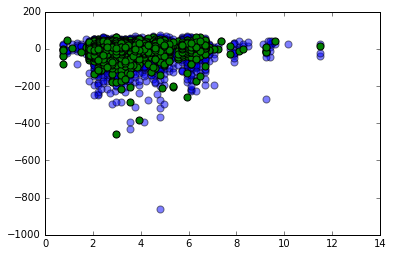

In [37]:
clf = sklearn.linear_model.LinearRegression()
clf.fit(X_train, y_train)
plt.scatter(clf.predict(X_train),clf.predict(X_train) - y_train, c = 'b', s=50, alpha = 0.5)
plt.scatter(clf.predict(X_test),clf.predict(X_test) - y_test, c = 'g', s=50)

In [148]:
clf = sklearn.linear_model.LinearRegression()

# fit the model!
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
rmse(y_test, y_pred)

34.170321112857643

As we seem, the RSME value of the OLS model is not acceptable, since the reduced dataset has some limitation, since, in our limited route dataset, the dependency between flight has decreased deeply.

In [110]:
X_train.shape, clf.coef_.shape

((6635, 29), (29,))

### Ridge Regression

In [144]:
%%time
# Use ridge regression (i.e. Gaussian prior) and vary the lambda parameter using Grid search
from sklearn.linear_model import SGDRegressor
from sklearn.grid_search import GridSearchCV

SGD_params = {'alpha': 10.0 ** -np.arange(-2,8)}
SGD_model = GridSearchCV(SGDRegressor(random_state = 50), \
                         SGD_params, scoring = 'mean_absolute_error', cv = 11) # cross validate 6 times


# train the model, this might take some time...
SGD_model.fit(X_train, y_train)

CPU times: user 839 ms, sys: 9.91 ms, total: 849 ms
Wall time: 852 ms


In [145]:
y_pred = SGD_model.predict(X_test)
rmse(y_test, y_pred)

33.589696257310685

The RSME value after Ridge Regression is also unacceptable, so we decide to run regression model on our whole dataset.

## 4.3 RSME Value Comparing

Here we present 3 RSME values for comparing. They are baseline 1 year dataset(2015) and 5 year dataset(2011-2015)

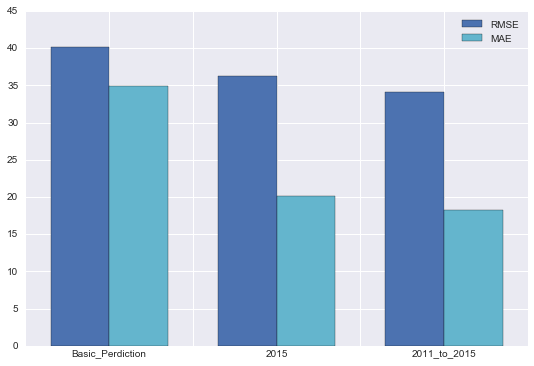

In [12]:
import json
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def load_model(filename):
    mdl = None
    with open(filename, 'r') as f:
        mdl = json.load(f)
    return mdl

# load model results
mdl1 = load_model('models/2015model.json') # model with 2014 data (1 year)
mdl5 = load_model('models/2011_2015model.json') # model with 2010-2014 data ( 5 years)


labels = np.array(['Basic_Perdiction', '2015', '2011_to_2015'])
RMSEs = np.array([RMSE_base, mdl1['RMSE'], mdl5['RMSE']])
MASs = np.array([MAS_base, mdl1['MAS'], mdl5['MAS']])

width = .35
xx = np.arange(len(RMSEs))
plt.figure(figsize=(9, 6))
plt.bar(xx-width, RMSEs, width, label='RMSE', color=sns.color_palette()[0])
plt.bar(xx , MASs, width, label='MAE', color=sns.color_palette()[5])
plt.legend(loc='best')

# Hide major tick labels
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.NullFormatter())

# Customize minor tick labels
ax.xaxis.set_minor_locator(ticker.FixedLocator([i for i in xx]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter([labels[i] for i in xx]))

# 5 Application for Detailed Flight

For our linear regression model, we add some limitations, since we decide to go to california after the final exam (around 12.17 to 12.23). Specific limitation:

Time:12.17 to 12.23,

Dest: Los Angles, CA,

Origin: Bosotn, MA.

In [124]:
from datetime import timedelta, datetime, tzinfo
from pytz import timezone
import pytz

def convertToUTC(naive, zonestring="America/New_York"):
    local = pytz.timezone (zonestring)
    local_dt = local.localize(naive, is_dst=None)
    return local_dt.astimezone (pytz.utc)

In [57]:
# we are only interested in flights NY to Chicago!
city_from = 'Boston, MA'
city_to = 'Los Angeles, CA'
zone_to = 'America/Los_Angeles'
zone_from = 'America/New_York'

In [58]:
# need to create a lookup table for the values (i.e. flight numbers, city and so on and then drop all duplicates!)
db = pd.read_csv('Big10FlightTable.csv')
# remove all unnecessary columns
db = db[['OriginCityName', 'DestCityName', 'AIRCRAFT_AGE', 'Dest', 'ArrTime', \
         'DepTime', 'UniqueCarrier', 'DayOfWeek', 'AIRCRAFT_MFR', 'FlightNum', 'Month', \
         'DayofMonth', 'Distance', 'Origin']]
print (str(db.count()[0]) + ' entries')
db.head()

# drop everything except for the 5 days before christmas! i.e. 20.12, 21.12, 22.12, 23.12, 24.12.
db = db[db.Month == 12]
db = db[db.DayofMonth <= 23]
db = db[db.DayofMonth >= 17]

print ('5 days have ' + str(db.count()[0]) + ' flights')

db = db[db.OriginCityName == city_from]
db = db[db.DestCityName == city_to]
db.reset_index(inplace=True)

print ('Found ' + str(db.count()[0]) + ' flights from ' + city_from + ' to ' + city_to + ' for 17.12 - 23.12')

20914271 entries
5 days have 403432 flights
Found 209 flights from Boston, MA to Los Angeles, CA for 17.12 - 23.12


In [59]:
mdl = load_model('models/2014model.json')
# categorical feature encoder, fitted on the keys
encoder = OneHotEncoder(sparse=True, n_values=mdl['encoder']['values']) 

In [60]:
# input is a datarow
# prediction of day in the next year!
def predictDelayTime(row, mdl):
    
    s_mean, s_std, coeff, intercept = mdl['scaler_mean'], mdl['scaler_std'], mdl['coeff'], mdl['intercept']
    
    # read out tables
    carrierTable = mdl['CARRIER']
    mfrTable = mdl['MANUFACTURER']
    destTable = mdl['DEST']
    originTable = mdl['ORIGIN']
    
    distance = row['Distance'] # <-- look this up!
    aircraft_age = row['AIRCRAFT_AGE'] # <-- look this up!
    
    # normalize numerical features according to scaler
    distance = (distance - s_mean[0]) / s_std[0]
    aircraft_age = (aircraft_age + 1 - s_mean[1]) / s_std[1]
    
    month = row['Month']
    day_of_month = row['DayofMonth'] 
    origin = row['Origin']
    dest = row['Dest']
    
    hour_of_arr = int(row['ArrTime']) / 10
    hour_of_dep = int(row['DepTime']) / 10
    carrier = row['UniqueCarrier']
    day_of_week = datetime(year=2016, month=row.Month, day=row.DayofMonth).weekday() # <-- get via datetimeobject
    mfr = row['AIRCRAFT_MFR']
    
    # for nonindexed categorical features, do lookup!
    origin = originTable[origin]
    dest = destTable[dest]
    mfr = mfrTable[mfr]
    carrier = carrierTable[carrier]

    # write into df
    df = {}
    df['MONTH'] = month
    df['DAY_OF_MONTH'] = day_of_month
    df['ORIGIN'] = origin
    df['DEST'] = dest
    df['HOUR_OF_ARR'] = hour_of_arr
    df['HOUR_OF_DEP'] = hour_of_dep
    df['UNIQUE_CARRIER'] = carrier
    df['DAY_OF_WEEK'] = day_of_week
    df['AIRCRAFT_MFR'] = mfr
    df = pd.DataFrame([df])

    # order here is important! make sure it is the same as in the model!
    categoricalFeat = df[['MONTH', 'DAY_OF_MONTH', 'ORIGIN', 
                    'DEST', 'HOUR_OF_ARR', 'HOUR_OF_DEP', 
                    'UNIQUE_CARRIER', 'DAY_OF_WEEK', 'AIRCRAFT_MFR']].copy() # Categorical features
    
    # construct the data vector for the linear model
    categoricals_encoded = encoder.fit_transform(categoricalFeat)
    num_features = np.array([distance, aircraft_age])
    cat_features = categoricals_encoded.toarray().T.ravel()
    w = np.hstack([num_features, cat_features])

    y_pred = np.dot(w, coeff) + intercept
    
    return y_pred[0]

In [51]:
row

index                            3792024
OriginCityName                Boston, MA
DestCityName             Los Angeles, CA
AIRCRAFT_AGE                          21
Dest                                 LAX
ArrTime                              923
DepTime                              609
UniqueCarrier                         UA
DayOfWeek                              6
AIRCRAFT_MFR                      BOEING
FlightNum                            704
Month                                 12
DayofMonth                            17
Distance                            2611
Origin                               BOS
PREDICTED_DELAY                        0
FLIGHT_TIME                            0
PREDICTED_FLIGHT_TIME                  0
Name: 0, dtype: object

In [61]:
# create for each day info
db['PREDICTED_DELAY'] = 0.
db['FLIGHT_TIME'] = 0
db['PREDICTED_FLIGHT_TIME'] = 0
for index, row in db.iterrows():
    print ('processing {idx}'.format(idx=index))
    y_pred = predictDelayTime(row, mdl)
    db.set_value(index, 'PREDICTED_DELAY', y_pred)

    arr_time = datetime(year=2016, month=row['Month'], day=row['DayofMonth'], \
                        hour= int(row['ArrTime'] / 100), minute=int(row['ArrTime'] % 100))
    dep_time = datetime(year=2016, month=row['Month'], day=row['DayofMonth'], \
                        hour= int(row['DepTime'] / 100), minute=int(row['DepTime'] % 100))
    
    flight_time_in_min =  (convertToUTC(arr_time) - convertToUTC(dep_time))
    flight_time_in_min = int(flight_time_in_min.total_seconds() / 60)
    
    db.set_value(index, 'FLIGHT_TIME', flight_time_in_min)
    db.set_value(index, 'PREDICTED_FLIGHT_TIME', y_pred + flight_time_in_min)

processing 0
processing 1
processing 2
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 18
processing 19
processing 20
processing 21
processing 22
processing 23
processing 24
processing 25
processing 26
processing 27
processing 28
processing 29
processing 30
processing 31
processing 32
processing 33
processing 34
processing 35
processing 36
processing 37
processing 38
processing 39
processing 40
processing 41
processing 42
processing 43
processing 44
processing 45
processing 46
processing 47
processing 48
processing 49
processing 50
processing 51
processing 52
processing 53
processing 54
processing 55
processing 56
processing 57
processing 58
processing 59
processing 60
processing 61
processing 62
processing 63
processing 64
processing 65
processing 66
processing 67
processing 68
processing 69
processing 70
processing 71
pr

In [62]:
db.columns

Index(['index', 'OriginCityName', 'DestCityName', 'AIRCRAFT_AGE', 'Dest',
       'ArrTime', 'DepTime', 'UniqueCarrier', 'DayOfWeek', 'AIRCRAFT_MFR',
       'FlightNum', 'Month', 'DayofMonth', 'Distance', 'Origin',
       'PREDICTED_DELAY', 'FLIGHT_TIME', 'PREDICTED_FLIGHT_TIME'],
      dtype='object')

In [63]:
db2 = db[db.DayofMonth == 17]
dbres2 = db2.sort('PREDICTED_FLIGHT_TIME')

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [64]:
dbres2.to_csv('desired_flights.csv')

For the detail departure time, we limit the time from 8am to 5pm

In [69]:
db3 = db[(db.DepTime > 800) & (db.DepTime < 1700)]
dbres3 = db2.sort('PREDICTED_FLIGHT_TIME')
dbres3.head()

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,index,OriginCityName,DestCityName,AIRCRAFT_AGE,Dest,ArrTime,DepTime,UniqueCarrier,DayOfWeek,AIRCRAFT_MFR,FlightNum,Month,DayofMonth,Distance,Origin,PREDICTED_DELAY,FLIGHT_TIME,PREDICTED_FLIGHT_TIME
173,20734828,"Boston, MA","Los Angeles, CA",6,LAX,32.0,2107.0,B6,4,AIRBUS,687,12,17,2611.0,BOS,49.615635,-1235,-1185
80,12398825,"Boston, MA","Los Angeles, CA",8,LAX,46.0,2026.0,B6,2,AIRBUS,687,12,17,2611.0,BOS,54.838259,-1180,-1125
108,12662980,"Boston, MA","Los Angeles, CA",15,LAX,229.0,2246.0,UA,2,BOEING,1010,12,17,2611.0,BOS,98.805784,-1217,-1118
0,3792024,"Boston, MA","Los Angeles, CA",21,LAX,923.0,609.0,UA,6,BOEING,704,12,17,2611.0,BOS,-9.190021,194,184
78,12398678,"Boston, MA","Los Angeles, CA",0,LAX,1158.0,847.0,B6,2,AIRBUS,287,12,17,2611.0,BOS,0.647968,191,191


And now we get several recommend flight for consideration. So we should book a ticket to LA in 12.17, just after our final exam.